### Этот ноутбук посвящён анализу российского ИПЦ в R.

R обладает не слишком широкими возможностями для программирования (специфицеская и ограниченная реализация ООП, отсталые библиотеки для ML, неудобный синтаксис, отвратная графика), но незаменим для эконометрики и особенно временных рядов. В этом плане Python отстаёт. Поэтому довольно логичный подход - использовать R для анализа временных рядов и предварительного выбора спецификации модели, а в Python реализовать загрузку и предобработку данных, а также выбор модели на кросс-валидации, если, допустим, понадобится.

In [12]:
# loading libraries
library(urca)
library(tidyverse)
library(dplyr)
library(readxl)
library(zoo)
library(xts)
library(forecast)
library(ggplot2)
library(urca)
library(repr) # размер графиков

Загрузим данные и посмотрим на них.

In [13]:
cpi <- read.table('data/clean_data.csv', header = TRUE, sep=',')
cpi$month <- as.Date(cpi$month)
# отфильтруем значения до 2000 года - выкинем гиперинфляцию
cpi <- cpi[cpi$month>="2000-01-31", ]
glimpse(cpi)

Observations: 264
Variables: 8
$ month           <date> 2000-01-31, 2000-02-29, 2000-03-31, 2000-04-30, 20...
$ cpi             <dbl> 0.0233, 0.0104, 0.0064, 0.0089, 0.0175, 0.0255, 0.0...
$ foods           <dbl> 0.0217, 0.0046, 0.0009, 0.0030, 0.0217, 0.0326, 0.0...
$ nonfoods        <dbl> 0.0217, 0.0132, 0.0138, 0.0149, 0.0109, 0.0083, 0.0...
$ services        <dbl> 0.0337, 0.0297, 0.0145, 0.0214, 0.0134, 0.0302, 0.0...
$ foods_weight    <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ nonfoods_weight <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ services_weight <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...


Посмотрим на графике, что все ряды загрузились верно.

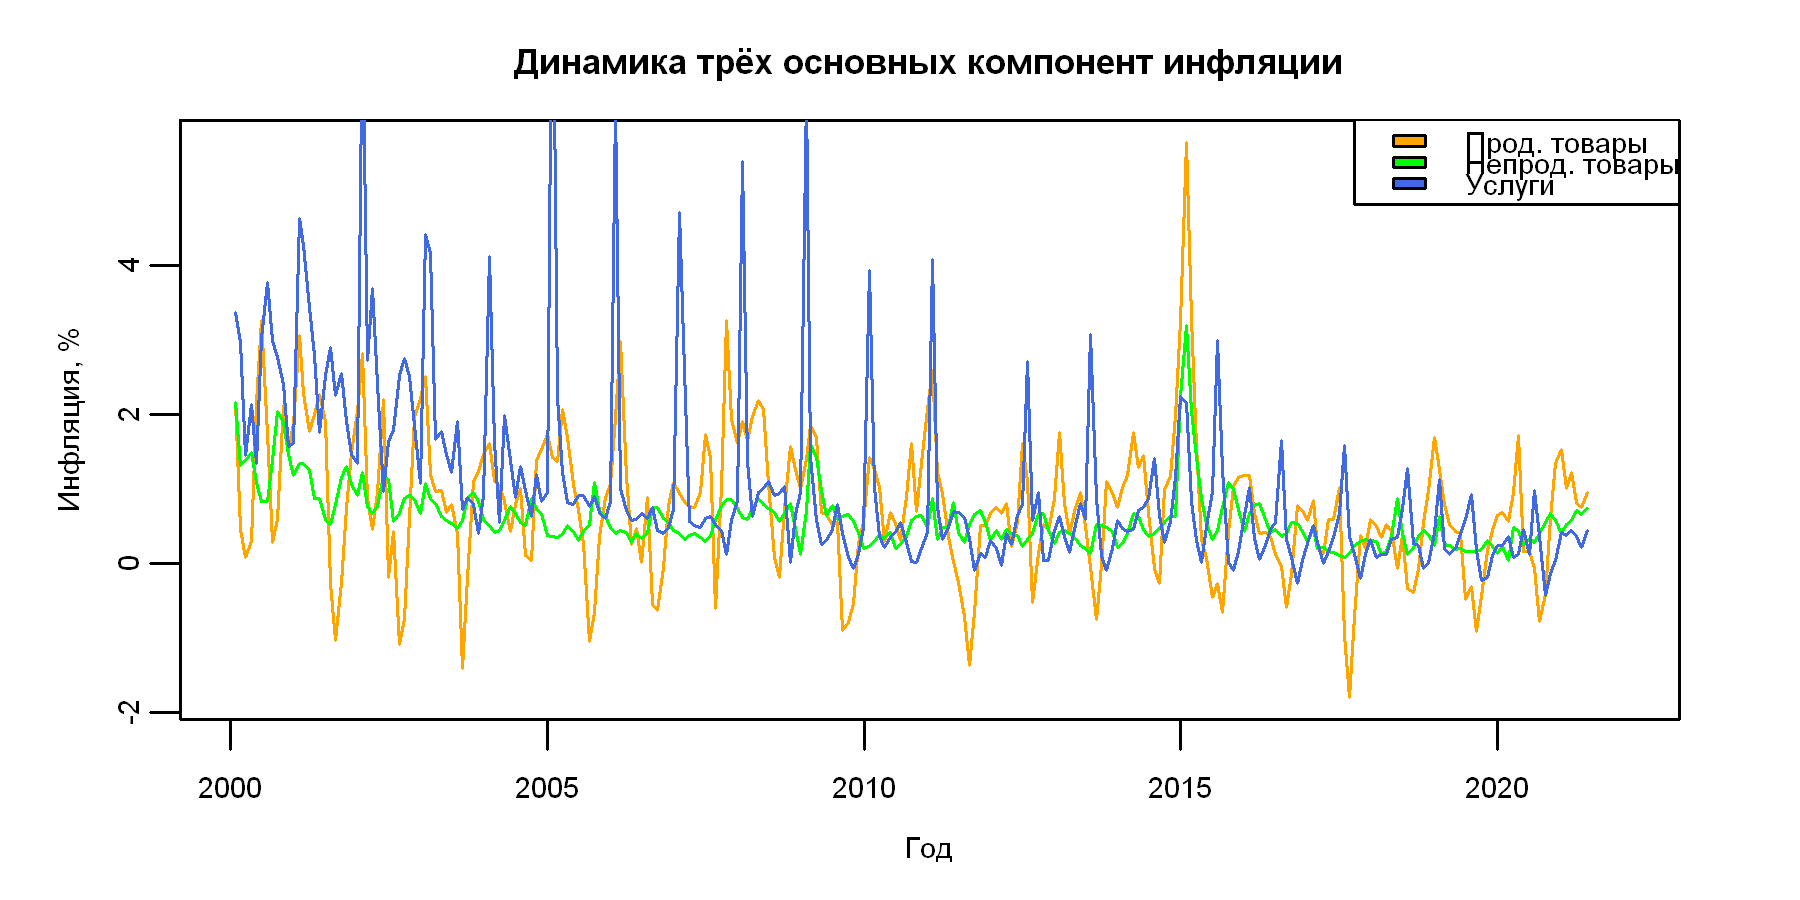

In [55]:
par(ps=7,
    # первая цифра - расстояние от названий оси до оси, 
    # вторая - от оси до её подписей
    # третья - от чёрточек на оси до самой оси
    mgp=c(1.5,0.5,0),
    # размер полей с четырёх сторон графика
    mar=c(3,3,2,2))
options(repr.plot.width=6, repr.plot.height=3, repr.plot.res=300)

plot(cpi$month, cpi$foods*100, type='l', col='orange', 
     xlab = 'Год', 
     ylab='Инфляция, %',
     main='Динамика трёх основных компонент инфляции')
lines(cpi$month, cpi$nonfoods*100, type='l', col='green')
lines(cpi$month, cpi$services*100, type='l', col='royalblue')
legend('topright',
       #cex = 0.9,
       legend = c('Прод. товары',
                  'Непрод. товары',
                  'Услуги'),
       fill = c('orange', 'green', 'royalblue'))

#### Инфляция цен на продовольственные товары.

#### Инфляция цен на непродовольственные товары.

#### Инфляция цен на услуги.

Посмотрим на динамику ряда.

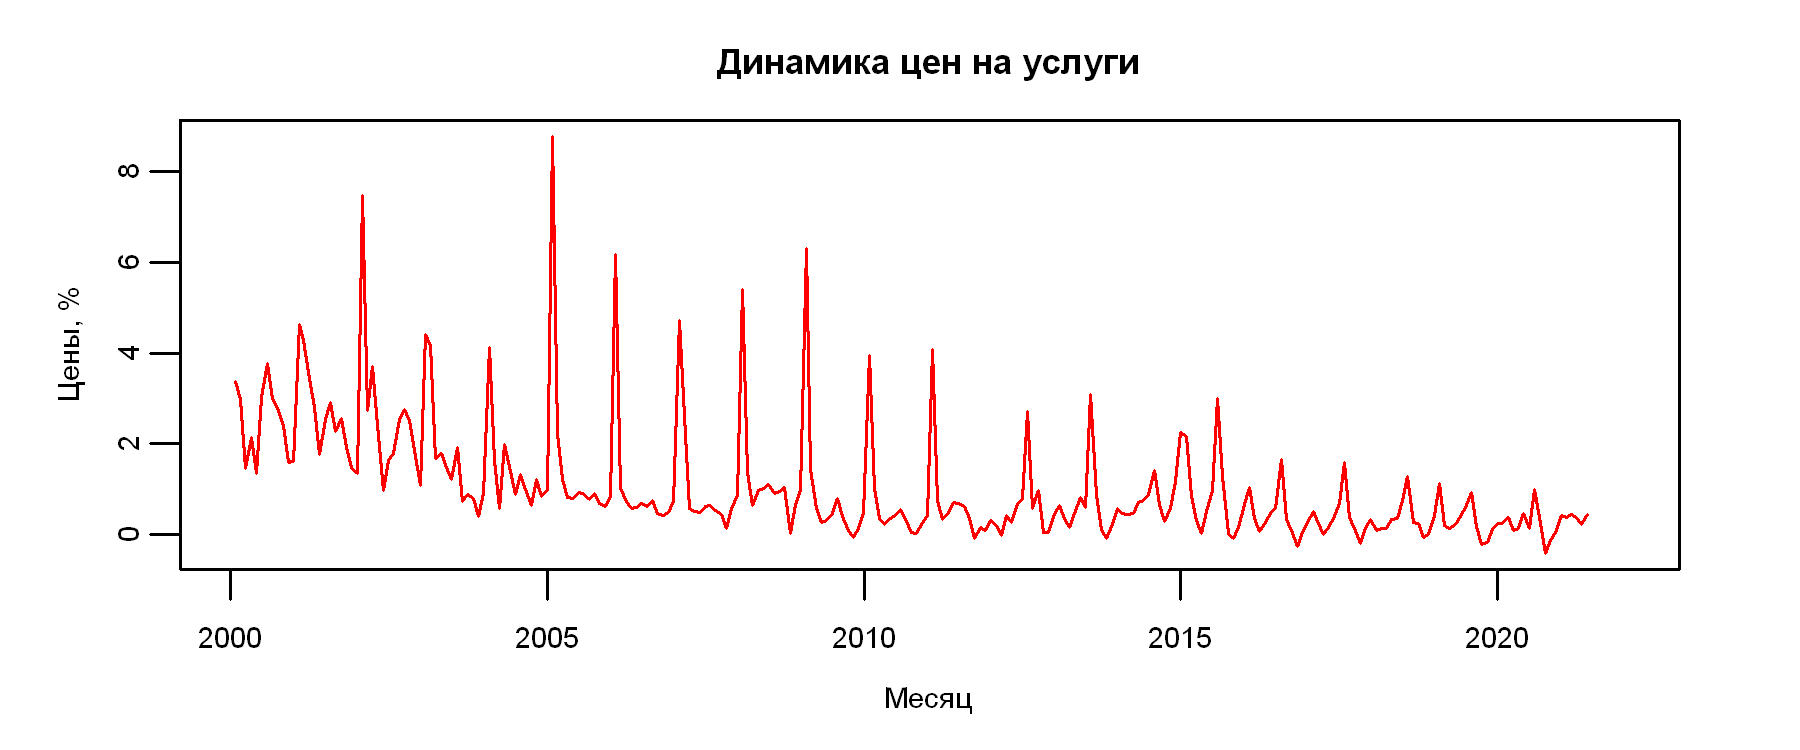

In [61]:
par(ps=7, mgp=c(1.5,0.5,0), mar=c(3,3,2,2))
options(repr.plot.width=6, repr.plot.height=2.5, repr.plot.res=300)
plot(cpi$month, cpi$services*100, 
     type='l', 
     col='red',
     main='Динамика цен на услуги',
     xlab='Месяц',
     ylab='Цены, %')

Ряд выводов по графику:
* заметна выраженная сезонность
* видно, что волатильность цен на услуги всё время снижается
* возможно, стоит применить преобразование Бокса-Кокса
* кроме того, заметен тренд на снижение среднего роста цен вне зависимости от сезонности 
* хотя небольшой рост инфляции наблюдался в 2014-15 годах, в целом не видится осмысленным использовать отдельную дамми в этом случае. С теоретической точки зрения, валютный шок скорее отразился в ценах на продовольственные и непродовольственные товары, чем в стоимости услуг.


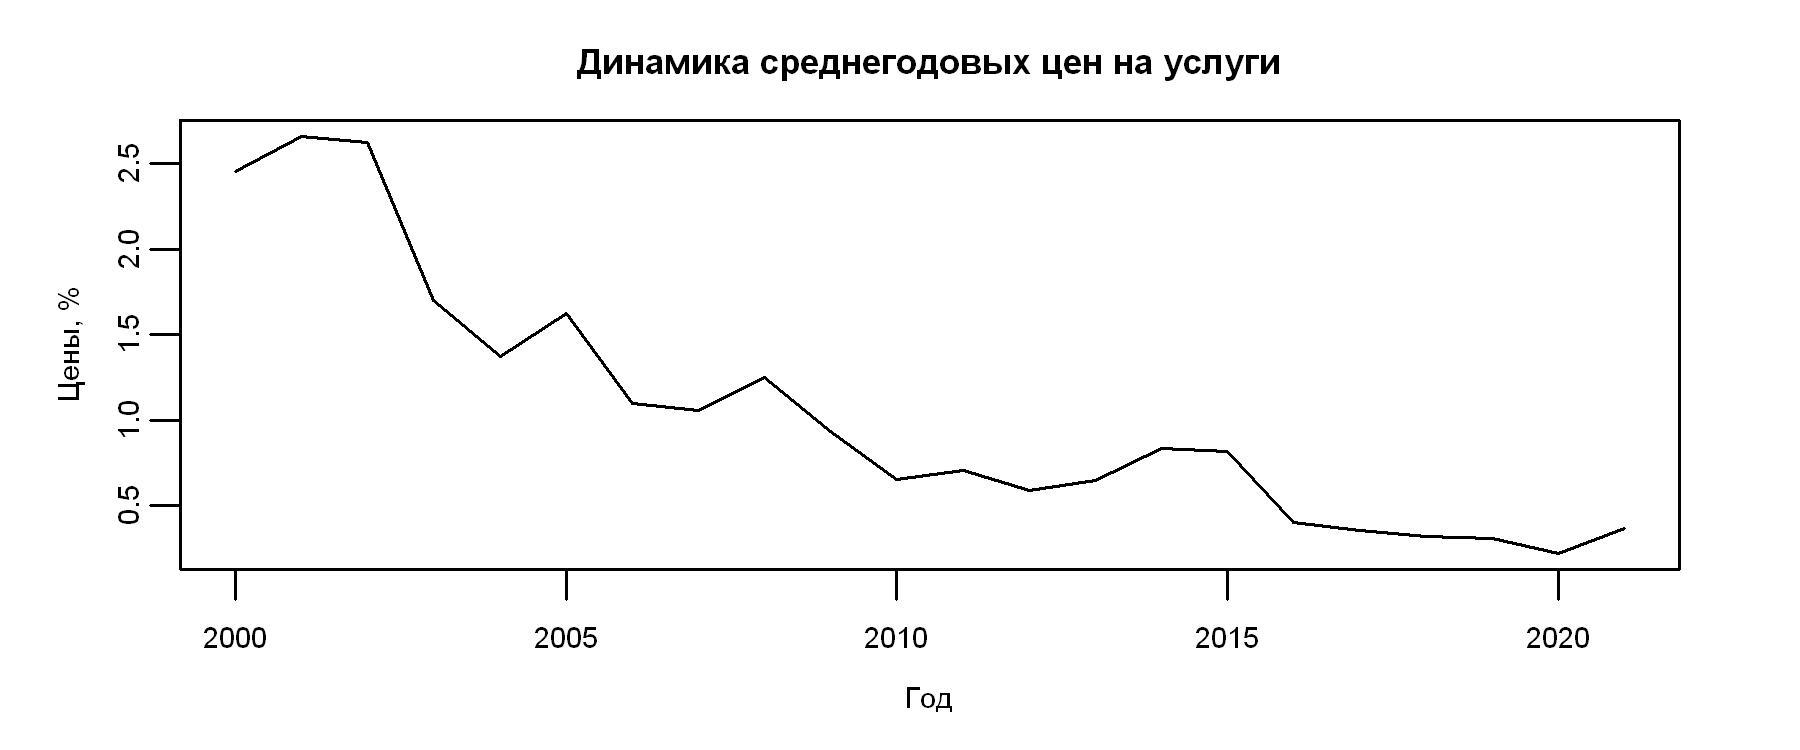

In [64]:
avgYearly <- function(ts, dates){
  ts <- na.omit(ts)
  years <- format(dates, '%Y')
  return(tapply(ts, years, mean))
}

sub <- na.omit(cpi[ ,c('month', 'services')])
years <- format(sub$month, '%Y')

par(ps=7, mgp=c(1.5,0.5,0), mar=c(3,3,2,2))
options(repr.plot.width=6, repr.plot.height=2.5, repr.plot.res=300)
plot(unique(years), avgYearly(sub$services, sub$month)*100, 
     type='l', 
     col='black',
     main='Динамика среднегодовых цен на услуги',
     xlab='Год',
     ylab='Цены, %')

Посмотрим на ACF, PACF.

Warning message:
"Removed 7 rows containing missing values (geom_point)."

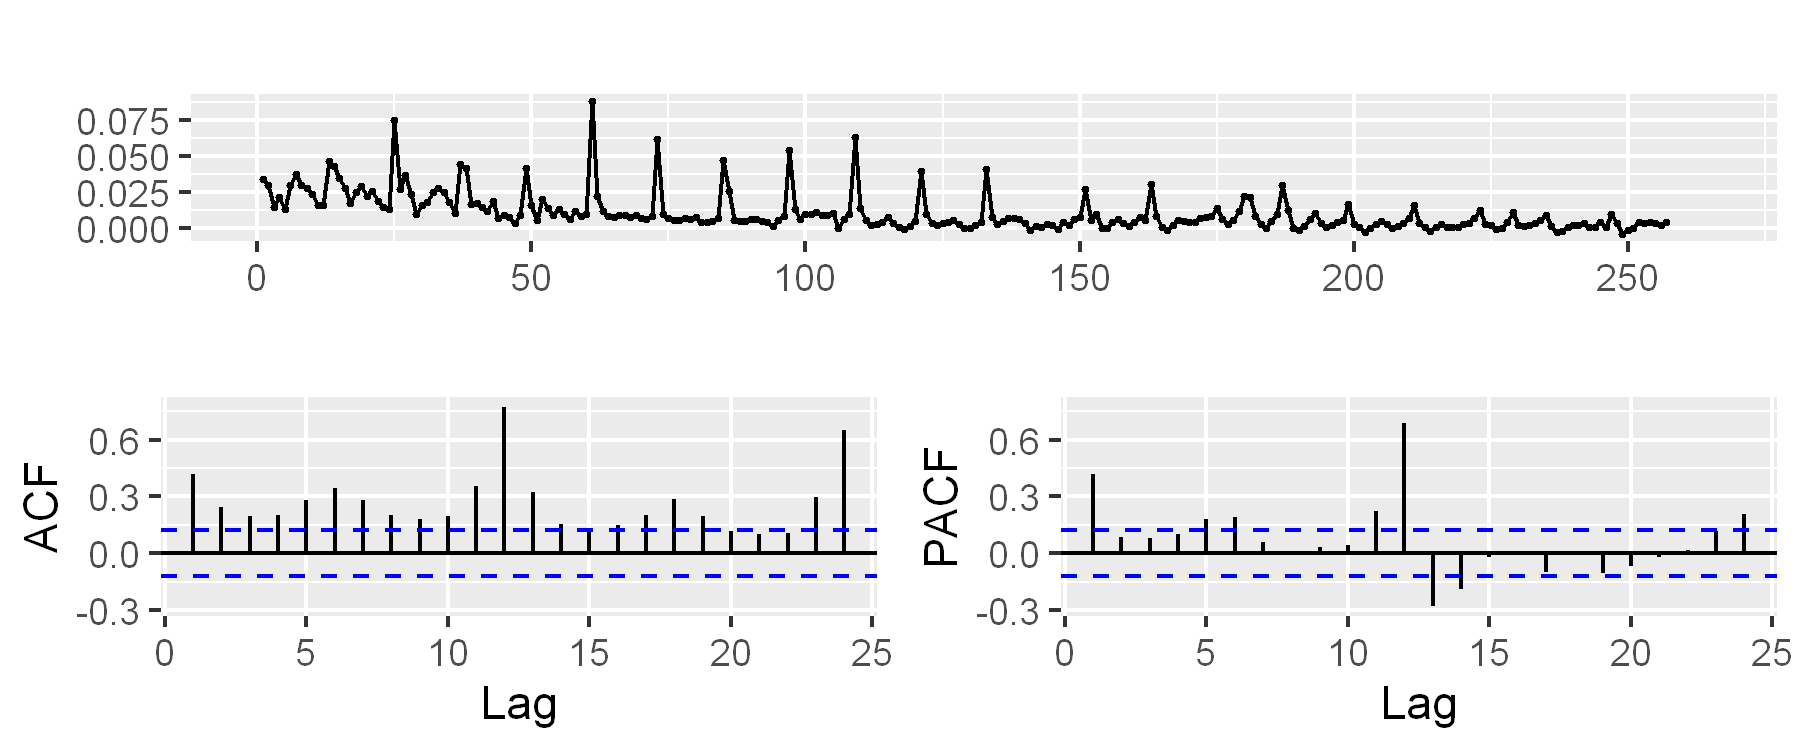

In [89]:
ggtsdisplay(cpi$services)

По графику можно предположить ARIMA((1,12) 0, 12).
Графика ужасна, но ggtdisplay - это обёртка вокруг tsdisplay и так далее, до исходных параметров графика там не добраться.

Разберёмся со стационарностью ряда - на графиках заметен явно убывающий тренд.

In [90]:
services_adf <- ur.df(na.omit(cpi$services), type='drift')
summary(services_adf)
ndiffs(coredata(cpi$services), test = 'kpss')
ndiffs(coredata(cpi$services), test = 'adf')


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.019323 -0.005544 -0.002625  0.000492  0.077908 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.005553   0.001030   5.390 1.62e-07 ***
z.lag.1     -0.535974   0.067357  -7.957 5.99e-14 ***
z.diff.lag  -0.089154   0.062333  -1.430    0.154    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01183 on 252 degrees of freedom
Multiple R-squared:  0.3014,	Adjusted R-squared:  0.2958 
F-statistic: 54.35 on 2 and 252 DF,  p-value: < 2.2e-16


Value of test-statistic is: -7.9572 31.6773 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.87 -2.57
phi1  6.47  4.61  3.79


[1] 1

[1] 0

KPSS тест советует взять первую разность, ADF - не брать разности. А что скажет auto.arima?

In [91]:
services_model <- auto.arima(cpi$services)
summary(services_model)

Series: cpi$services 
ARIMA(1,1,1) with drift 

Coefficients:
         ar1      ma1   drift
      0.1741  -0.9688  -1e-04
s.e.  0.0639   0.0166   1e-04

sigma^2 estimated as 0.0001207:  log likelihood=791.9
AIC=-1575.81   AICc=-1575.65   BIC=-1561.63

Training set error measures:
                        ME       RMSE        MAE  MPE MAPE      MASE       ACF1
Training set -0.0001784192 0.01089936 0.00644369 -Inf  Inf 0.8761803 0.01564031


In [105]:
services_model2 <- Arima(cpi$services, 
                         order = c(1,0,1), 
                         seasonal = list("order" = c(1,0,1), "period" = 12))

In [106]:
summary(services_model2)

Series: cpi$services 
ARIMA(1,0,1)(1,0,1)[12] with non-zero mean 

Coefficients:
         ar1      ma1    sar1     sma1    mean
      0.7987  -0.5452  0.9149  -0.4102  0.0118
s.e.  0.1162   0.1719  0.0261   0.0655  0.0048

sigma^2 estimated as 4.913e-05:  log likelihood=906.22
AIC=-1800.43   AICc=-1800.1   BIC=-1779.14

Training set error measures:
                        ME        RMSE         MAE  MPE MAPE      MASE
Training set -0.0006092266 0.006940813 0.004191671 -Inf  Inf 0.5699622
                    ACF1
Training set -0.01023157


В общем, особенного удобства по сравнению с Rstudio нет, поэтому дальше всё буду делать в ней, а не здесь.